# Preprocessing

## Install / Import all Python Modules Required

In [1]:
! pip install contractions

In [2]:
! pip install python-dotenv

In [3]:
! pip install nltk

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

import re
import string
import contractions
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences


from dotenv import load_dotenv, find_dotenv
import os

In [5]:
pd.set_option('display.max_colwidth', None)

## Load the Datasets required (Train Set, Validation Set, Test Set)

In [6]:
#loading the datasets
train_set = pd.read_csv('../raw_data/train.csv')
validation_set = pd.read_csv('../raw_data/validation.csv')
test_set = pd.read_csv('../raw_data/test.csv')

## Drop Useless Columns

In [7]:
# droppping useless columns
train_data = train_set.drop(['id', 'orig_id'], axis=1)[:800]
val_data = validation_set.drop(['id', 'orig_id'], axis=1)[:200]
test_data = test_set.drop(['id', 'orig_id'], axis=1)[:100]

In [8]:
train_data.shape

(800, 2)

In [9]:
train_data[6:8]

article  \
6  BAGHDAD, Iraq (CNN) -- The women are too afraid and ashamed to show their faces or have their real names used. They have been driven to sell their bodies to put food on the table for their children -- for as little as $8 a day. Suha, 37, is a mother of three. She says her husband thinks she is cleaning houses when she leaves home. "People shouldn't criticize women, or talk badly about them," says 37-year-old Suha as she adjusts the light colored scarf she wears these days to avoid extremists who insist women cover themselves. "They all say we have lost our way, but they never ask why we had to take this path." A mother of three, she wears light makeup, a gold pendant of Iraq around her neck, and an unexpected air of elegance about her. "I don't have money to take my kid to the doctor. I have to do anything that I can to preserve my child, because I am a mother," she says, explaining why she prostitutes herself. Anger and frustration rise in her voice as she speaks. "No matter what else I may be, no matter how off the path I may be, I am a mother!"  Watch a woman describe turning to prostitution to "save my child" » . Her clasped hands clench and unclench nervously. Suha's husband thinks that she is cleaning houses when she goes away. So does Karima's family. "At the start I was cleaning homes, but I wasn't making much. No matter how hard I worked it just wasn't enough," she says. Karima, clad in all black, adds, "My husband died of lung cancer nine months ago and left me with nothing." She has five children, ages 8 to 17. Her eldest son could work, but she's too afraid for his life to let him go into the streets, preferring to sacrifice herself than risk her child. She was solicited the first time when she was cleaning an office. "They took advantage of me," she says softly. "At first I rejected it, but then I realized I have to do it." Both Suha and Karima have clients that call them a couple times a week. Other women resort to trips to the market to find potential clients. Or they flag down vehicles. Prostitution is a choice more and more Iraqi women are making just to survive. "It's increasing," Suha says. "I found this 'thing' through my friend, and I have another friend in the same predicament as mine. Because of the circumstance, she is forced to do such things." Violence, increased cost of living, and lack of any sort of government aid leave women like these with few other options, according to humanitarian workers. "At this point there is a population of women who have to sell their bodies in order to keep their children alive," says Yanar Mohammed, head and founder of the Organization for Women's Freedom in Iraq. "It's a taboo that no one is speaking about." She adds, "There is a huge population of women who were the victims of war who had to sell their bodies, their souls and they lost it all. It crushes us to see them, but we have to work on it and that's why we started our team of women activists." Her team pounds the streets of Baghdad looking for these victims often too humiliated to come forward. "Most of the women that we find at hospitals [who] have tried to commit suicide" have been involved in prostitution, said Basma Rahim, a member of Mohammed's team. The team's aim is to compile information on specific cases and present it to Iraq's political parties -- to have them, as Mohammed puts it, "come tell us what [they] are ... going to do about this." Rahim tells the heartbreaking story of one woman they found who lives in a room with three of her children: "She has sex while her three children are in the room, but she makes them stand in separate corners." According to Rahim and Mohammed, most of the women they encounter say they are driven to prostitution by a desperate desire for survival in the dangerously violent and unforgiving circumstances in Iraq. "They took this path but they are not pleased," Rahim says. Karima says when she sees her children with food on the table, she is able to convi

In [10]:
print(f"train_data.shape: {train_data.shape}")

train_data.shape: (800, 2)


## Check if there are any Empty Cells in the DataFrame

In [11]:
train_data.isna().sum()

article       0
highlights    0
dtype: int64

In [12]:
test_data.isna().sum()

article       0
highlights    0
dtype: int64

## Dealing with Duplicates / Drop Duplicates in the Train, Validation and Test Sets

In [13]:
train_data.duplicated(subset=['article', 'highlights']).sum()

31

In [14]:
val_data.duplicated(subset=['article', 'highlights']).sum()

0

In [15]:
test_data.duplicated(subset=['article', 'highlights']).sum()

0

In [16]:
def del_duplicates(dataset, columns_to_compare):
    '''
    Function that deletes duplicated lines comapres according to indicated columns
    '''
    return dataset.drop_duplicates(subset=columns_to_compare)

In [17]:
cols = ['article', 'highlights']

train = del_duplicates(train_data, columns_to_compare=cols)
train.shape

(769, 2)

In [18]:
val = del_duplicates(val_data, columns_to_compare=cols)
val.shape

(200, 2)

In [19]:
test = del_duplicates(test_data, columns_to_compare=cols)
test.shape

(100, 2)

## Potential threshhold for news extraction / Check the Statistical Distribution of Word Counts for Articles and Summaries

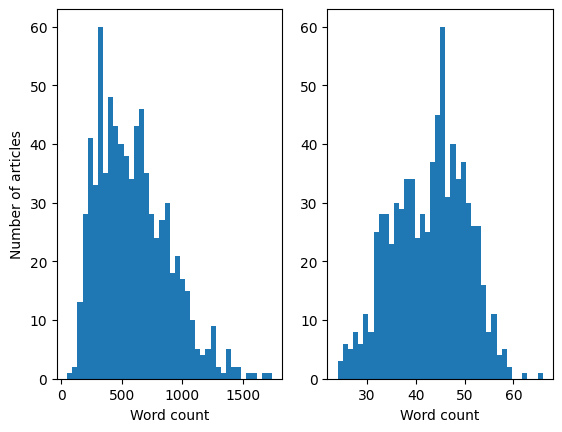

In [20]:
# word count
article_wc = []
summary_wc = []

# populate the lists with sentence lengths
for i in train.article:
      article_wc.append(len(i.split()))

for i in train.highlights:
      summary_wc.append(len(i.split()))

length_df = pd.DataFrame({'text':article_wc, 'summary':summary_wc})

plt.subplot(1, 2, 1)
plt.hist(length_df.text, bins=40)
plt.xlabel("Word count")
plt.ylabel("Number of articles")


plt.subplot(1, 2, 2)
plt.hist(length_df.summary, bins=40)
plt.xlabel("Word count")


plt.show()

## Clean the Data

### Prepare a Function "Preprocessing" to perform the single cleaning steps

- Transform upper cases to lower cases
- Remove return characters, url and html tags
- Expand shortened words via Contractions
- Remove any parentheses with text inside
- Remove special characters, remove whitespaces

In [21]:
def preprocessing(sentence: string, remove_stopwords=True) -> string: 
    
    '''
    Preprocessing text: lower case, 
                        deleting punctuation, 
                        replacing contructions with equivalent,
                        deleting stop words,
                        removing special characters
    '''

    # Lowercase
    sentence = sentence.lower()
   
    # Remove return characters, url and html tags
    code_list = ['\n', '\S*(http|https)\S*', '\<a href', '&amp;', '<br />']
    for code in code_list:
        sentence = re.sub(code, ' ',sentence, flags=re.MULTILINE)
    
    # expand the shortened words (can't => can not)
    # after they will be deleted in stopwords
    expanded = []   
    for word in sentence.split():
        expanded.append(contractions.fix(word, slang=False))
        
    expanded_sentence = ' '.join(expanded)
    
    # remove any parenthisis with text inside
    sentence = re.sub(r'\([^)]*\)', '', expanded_sentence)
        # Removing punctuation, url and html tags
    for punctuation in string.punctuation + '[\'\"]':
        sentence = sentence.replace(punctuation, ' ')
        
    # remove special characters 
    sentence = re.sub("[^a-zA-Z]", " ", sentence)

    # Removing whitespaces
    sentence = sentence.strip()
                
    if remove_stopwords:
        stop_words = set(stopwords.words('english')) ## defining stopwords    
        sentence_list = [w for w in sentence.split() if not w in stop_words]
        sentence = (' '.join(sentence_list)).strip()
        
    return sentence

### Test the function "Preprocessing" prepared to clean the data on a subset to check if it works

In [22]:
def cleaning(dataset: pd.Series, remove_stopwords=True) -> list:
    '''
    This function creates a cleaned version of each dataset.
    Calls the preprocessing function.
    '''
    
    clean = []
    for text in dataset:
        clean.append(preprocessing(text, remove_stopwords=True))
    return clean

In [23]:
%%time

X_train = cleaning(train.article)
y_train = cleaning(train.highlights, remove_stopwords=False)

CPU times: user 2.85 s, sys: 115 ms, total: 2.96 s
Wall time: 3.19 s


In [24]:
print(f'Clean article : {X_train[0]}')
print('\n')
print(f'Clean summary : {y_train[0]}')

Clean article : london england harry potter star daniel radcliffe gains access reported million fortune turns monday insists money cast spell daniel radcliffe harry potter harry potter order phoenix disappointment gossip columnists around world young actor says plans fritter cash away fast cars drink celebrity parties plan one people soon turn suddenly buy massive sports car collection something similar told australian interviewer earlier month think particularly extravagant things like buying things cost pounds books cds dvds radcliffe able gamble casino buy drink pub see horror film hostel part ii currently six places number one movie uk box office chart details mark landmark birthday wraps agent publicist comment plans definitely sort party said interview hopefully none reading radcliffe earnings first five potter films held trust fund able touch despite growing fame riches actor says keeping feet firmly ground people always looking say kid star goes rails told reporters last month 

In [25]:
%%time

X_val = cleaning(val.article)
y_val = cleaning(val.highlights, remove_stopwords=False)

CPU times: user 661 ms, sys: 27.4 ms, total: 688 ms
Wall time: 734 ms


In [26]:
%%time

X_test = cleaning(test.highlights, remove_stopwords=False)
y_test = cleaning(test.article)

CPU times: user 383 ms, sys: 19.1 ms, total: 402 ms
Wall time: 443 ms


### !!! Only for target data => adding "start" and "stop" to the sequence

In [27]:
def adding_decoder_tokens(data: pd.Series) -> pd.Series:
    '''
    Adding special tokens for the decoder only to target string
    '''
    
    return pd.Series(data).apply(lambda x : '_START_ '+ x + ' _END_')

y_train = adding_decoder_tokens(y_train)
y_val = adding_decoder_tokens(y_val)

In [28]:
y_train[0]

'_START_ harry potter star daniel radcliffe gets fortune turns monday young actor says plans fritter cash away radcliffe earnings first five potter films held trust fund _END_'

# Tokenization

## Initialize the max len for Article and Summary

In [29]:
# initialize the max len for article and summary
max_len_text = 80
max_len_summary= 10

## Article Tokenization

### Transform each Article in articles to a sequence of Integers

The result of this step are the lists X_train_tok and X_val_tok that basically are lists of tokenized articles in turn being lists of words transformed to integers

In [30]:
# learning the dictionnary from train articles
X_tokenizer = Tokenizer()
X_tokenizer.fit_on_texts(list(X_train))

# Transforms each article in articles to a sequence of integers.
X_train_tok = X_tokenizer.texts_to_sequences(X_train) 
X_val_tok = X_tokenizer.texts_to_sequences(X_val)

In [31]:
print('Tokenized article looks like this : ')
print(X_train_tok[0])

Tokenized article looks like this : 
[226, 334, 1145, 4571, 608, 1733, 4572, 3940, 1175, 103, 88, 4573, 2458, 73, 5429, 257, 1927, 4976, 1733, 4572, 1145, 4571, 1145, 4571, 538, 3294, 4224, 11147, 14881, 115, 33, 282, 2159, 25, 490, 14882, 1680, 160, 1211, 888, 3475, 2359, 1611, 409, 2, 3, 589, 644, 4225, 982, 1212, 1612, 157, 2459, 171, 1039, 11, 1176, 11148, 162, 117, 38, 1007, 14883, 203, 23, 3476, 203, 799, 1520, 2073, 11149, 9049, 4572, 255, 11150, 4574, 982, 3475, 11151, 53, 3941, 1213, 11152, 101, 1803, 1476, 124, 1040, 185, 2, 950, 843, 1316, 152, 6720, 1248, 861, 5976, 1997, 7752, 1389, 9050, 914, 490, 2568, 1568, 111, 1, 583, 3694, 1430, 2460, 4572, 7753, 18, 121, 4571, 2960, 228, 951, 1431, 255, 2360, 596, 830, 4977, 7754, 2159, 25, 1928, 706, 7755, 417, 3, 283, 500, 46, 2461, 608, 844, 14884, 11, 501, 19, 117, 491, 340, 89, 65, 4, 952, 889, 6721, 590, 11153, 1145, 4571, 538, 3294, 1613, 1317, 1477, 2569, 14885, 479, 19, 6, 2960, 26, 1064, 284, 1734, 4571, 889, 76, 1249, 457

### Pad the Tokenized Articles to max_len_text

- The padding step shall ensure that all tokenized articles are split in a way that the results are lists of integers all having the same length max_len_text
- If a tokenized article is longer than max_len_text it is truncated
- If a tokenized article is shorter than max_len_text it is filled with 0's to reach a length of max_len_text

In [32]:
# post-padding with zeros up to maximum length
X_train_pad = pad_sequences(X_train_tok, dtype='float32', maxlen=max_len_text, padding='post') 
X_val_pad = pad_sequences(X_val_tok, dtype='float32', maxlen=max_len_text, padding='post')

X_vocab = len(X_tokenizer.word_index) + 1

In [33]:
print(f'The size of train articles vocabulary is {X_vocab}')

The size of train articles vocabulary is 24267


## Summary Tokenization

### Tokenize Summaries to lists of Integers

In [34]:
# learning the dictionnary from train summaries
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

# Transforms each summary in summaries to a sequence of integers.
y_train_tok = y_tokenizer.texts_to_sequences(y_train) 
y_val_tok = y_tokenizer.texts_to_sequences(y_val) 

### Pad the tokenized Summaries to a Length of max_len_summary

In [35]:
# post-padding with zeros up to maximum length
y_train_pad = pad_sequences(y_train_tok, dtype='float32', maxlen=max_len_summary, padding='post')
y_val_pad = pad_sequences(y_val_tok,  dtype='float32', maxlen=max_len_summary, padding='post')

y_vocab = len(y_tokenizer.word_index) + 1

In [36]:
print(f'The size of train summary vocabulary is {y_vocab}')

The size of train summary vocabulary is 6821


# Build the Model that will be Trained and will Predict Summaries of Articles based on the Training Performed

## Import Modules Potentially Required

In [37]:
import numpy as np
from keras import backend as K 
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings

warnings.filterwarnings("ignore")

## Define latent_dim & embedding_dim

- latent_dim is the dimension intended for the output of the Encoder, i.e. the first step of the Model
- embedding_dim is

In [38]:
latent_dim = 500
embedding_dim = 100

--------------------------------------------------------------------

## Step 1 of the Model: Embed the Inputs to the Encoder into the Latent Space

- The Encoder allocates the integers (being included in the tokenized and padded lists of integers) inserted into the Model into Vectors in the "Latent Space"
- Input shape is max_len_text as via the step before we have padded the lists of integers to a length of max_len_text
- X_Vocab is the length of the X_Tokenizer Word Index + 1, i.e. the number of integers + 1. Why "+1"? xxx
- latent_dim is the dimensionality of the output space
- The result of the Encoder, "enc_emb", is a Tensor having the shape (None, 300, 300)

In [39]:
# Add documentation for encoder
# shape: max_len_text, i.e. the maximum length of words of the input text we will insert into the model, correct?
# Embedding: X_vocab is the length of the X_Tokenizer Word Index + 1
# Embedding: latent_dim is the dimensionality of the output space

encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(X_vocab, latent_dim,trainable=True)(encoder_inputs)

2022-12-01 21:03:10.122641: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [40]:
enc_emb

<KerasTensor: shape=(None, 80, 500) dtype=float32 (created by layer 'embedding')>

## Step 2 of the Model: Three Stages of Stacked Long Short Term Memory (LSTM) Acting as the Encoder

There are three LSTM layers

The outputs of this step are

- encoder_outputs being a tensor with shape (None, max_len_text, max_len_text)
- state_h being a tensor with shape (none, max_len_text)
- state_c being a tensor with shape (none, max_len_text)

In [41]:
# LSTM 1 
# first integer shown in the brackets is the "dimensionality of the output space". so, that would be the length of the output summary, right?
# return_sequences = Boolean. Whether to return the last output in the output sequence, or the full sequence. Default: False.
# return_state = Boolean. Whether to return the last state in addition to the output. Default: False.

encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [42]:
encoder_output1

<KerasTensor: shape=(None, 80, 500) dtype=float32 (created by layer 'lstm')>

In [43]:
encoder_output2

<KerasTensor: shape=(None, 80, 500) dtype=float32 (created by layer 'lstm_1')>

In [44]:
encoder_outputs

<KerasTensor: shape=(None, 80, 500) dtype=float32 (created by layer 'lstm_2')>

In [45]:
state_h

<KerasTensor: shape=(None, 500) dtype=float32 (created by layer 'lstm_2')>

In [46]:
state_c

<KerasTensor: shape=(None, 500) dtype=float32 (created by layer 'lstm_2')>

In [47]:
encoder_outputs

<KerasTensor: shape=(None, 80, 500) dtype=float32 (created by layer 'lstm_2')>

## Step 3 of the Model: Setup the Decoder

In [48]:
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_vocab, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs)

In [49]:
dec_emb

<KerasTensor: shape=(None, None, 500) dtype=float32 (created by layer 'embedding_1')>

Decoder based on encoder_states as initial state

In [50]:
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

Attention Layer

In [51]:
#attn_layer = Attention(name='attention_layer') 
#attn_out = attn_layer([encoder_outputs, decoder_outputs]) 

attention = Attention(name='attention_layer')
attn_out = attention([decoder_outputs, encoder_outputs])

In [52]:
decoder_outputs

<KerasTensor: shape=(None, None, 500) dtype=float32 (created by layer 'lstm_3')>

In [53]:
encoder_outputs

<KerasTensor: shape=(None, 80, 500) dtype=float32 (created by layer 'lstm_2')>

Concatenate attention output and decoder LSTM output 

In [54]:
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

In [55]:
decoder_concat_input

<KerasTensor: shape=(None, None, 1000) dtype=float32 (created by layer 'concat_layer')>

Add a Dense Layer

In [56]:
#decoder_dense = Dense(y_vocab, activation='softmax')
decoder_dense = TimeDistributed(Dense(y_vocab, activation='softmax')) 
#decoder_outputs = decoder_dense(decoder_outputs)
decoder_outputs = decoder_dense(decoder_concat_input)

In [57]:
decoder_outputs

<KerasTensor: shape=(None, None, 6821) dtype=float32 (created by layer 'time_distributed')>

Define the Model

In [58]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 80, 500)      12133500    ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 80, 500),    2002000     ['embedding[0][0]']              
                                 (None, 500),                                                     
                                 (None, 500)]                                                     
                                                                                              

In [59]:
#dec_tr_data = dec_data.reshape(len(dec_data),max_tr_len,1)[:,1:]

In [60]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [61]:
model.compile( 
    optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"] ) 
history = model.fit( 
    [X_train_pad,y_train_pad[:,:-1]],
    y_train_pad.reshape(len(y_train_pad), max_len_summary, 1)[:,1:], 
    batch_size=512, 
    epochs=10,
    callbacks=[es],
    validation_split=0.1,
    )
 
#Save model
model.save("s2s")

Epoch 1/10


2022-12-01 21:03:20.903252: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 1200 num_cores: 4 environment { key: "cpu_instruction_set" value: "SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 4194304 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


2/2 [==============================] - ETA: 0s - loss: 8.8247 - accuracy: 0.0289      

2022-12-01 21:05:20.763165: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 1200 num_cores: 4 environment { key: "cpu_instruction_set" value: "SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 4194304 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


2/2 [==============================] - 136s 61s/step - loss: 8.8247 - accuracy: 0.0289 - val_loss: 8.1368 - val_accuracy: 0.1111
Epoch 2/10
2/2 [==============================] - 190s 48s/step - loss: 8.1139 - accuracy: 0.1114 - val_loss: 8.2866 - val_accuracy: 0.0130
Epoch 3/10
2/2 [==============================] - 169s 43s/step - loss: 7.6987 - accuracy: 0.0411 - val_loss: 8.1580 - val_accuracy: 0.1111
Epoch 3: early stopping


2022-12-01 21:12:03.840741: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: s2s/assets


INFO:tensorflow:Assets written to: s2s/assets


Compile the Model

In [62]:
#model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

Implement Early Stopping

In [63]:
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

Train the Model

In [64]:
#history=model.fit([X_train_pad,y_train_pad[:,:-1]], 
                #  y_train_pad.reshape(len(y_train_pad), max_len_summary, 1)[:,1:],
                 # epochs=50,callbacks=[es],batch_size=512, 
                  #validation_data=([X_val_pad,y_val_pad[:,:-1]], 
                   #                y_val_pad.reshape(y_val_pad.shape[0], y_val_pad.shape[1], 1)[:,1:]))

In [65]:
#history=model.fit([X_train_pad,y_train_pad[:,:-1]], 
 #                 y_train_pad.reshape(y_train_pad.shape[0], y_train_pad.shape[1], 1)[:,1:],
  #                epochs=50,callbacks=[es],batch_size=512, 
   #               validation_data=([X_val_pad,y_val_pad[:,:-1]], 
    #                               y_val_pad.reshape(y_val_pad.shape[0], y_val_pad.shape[1], 1)[:,1:]))

Diagnostics enabling us to check the course of losses for training and validation

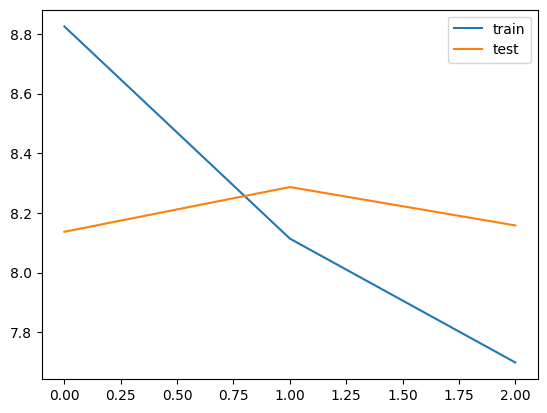

In [66]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [67]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=X_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

Inference Process

In [68]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attention = model.layers[8]
attn_out_inf = attention([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
#decoder_outputs2 = decoder_dense(decoder_inf_concat)
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [69]:
state_h2

<KerasTensor: shape=(None, 500) dtype=float32 (created by layer 'lstm_3')>

In [70]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, None, 500)    3410500     ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 500)]        0           []                               
                                                                                            

In [71]:
decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

[<KerasTensor: shape=(None, None, 500) dtype=float32 (created by layer 'lstm_3')>,
 <KerasTensor: shape=(None, 500) dtype=float32 (created by layer 'lstm_3')>,
 <KerasTensor: shape=(None, 500) dtype=float32 (created by layer 'lstm_3')>]

In [72]:
decoder_hidden_state_input

<KerasTensor: shape=(None, 80, 500) dtype=float32 (created by layer 'input_5')>

Function implementing the Inference Process

In [73]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

Function to transform Integers back to Words for our source sequence of Words



In [74]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

Function to transform Integers back to Words for our target sequence of Words

In [75]:
def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

Show the Output of our Model

In [76]:
for i in range(len(X_val_pad)):
    print("Review:",seq2text(X_val_pad[i]))
    print("Original summary:",seq2summary(y_val_pad[i]))
    print("Predicted summary:",decode_sequence(X_val_pad[i].reshape(1,max_len_text)))
    print("\n")

Review: list live donor came along someone nice enough give away kidney stranger jacobs paid forward programming skills creating program genetically matches donor pairs chains quickly five way swap years ago one largest took three four months three weeks jacobs said chain would worked quickly without generosity may worked significance altruistic donor opens possibilities donors recipients said dr steven three four options inclusion altruistic donor options consider matching donors recipients divine friend shirley williams wrote comment facebook page true angel friend 
Original summary: give kidney new computer program helped six kidney patients 


2022-12-01 21:12:31.333459: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 1200 num_cores: 4 environment { key: "cpu_instruction_set" value: "SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 32768 l2_cache_size: 262144 l3_cache_size: 4194304 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


KeyboardInterrupt: 